# Deep Auto Encoder

## Loading dataset

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import functools


compose = lambda *fs: functools.reduce(lambda f, g: lambda x: g(f(x)), fs)

def scale(sample):
    return {
        "image": tf.cast(sample["image"], tf.float32) / 255.,
        "label": sample["label"]
    }

def pad(sample, padding: tf.Tensor):
    return {
        "image": tf.pad(sample["image"], padding, "CONSTANT", constant_values=0.0),
        "label": sample["label"]
    }

def flatten(sample: tf.Tensor):
    return {
        "image": tf.reshape(sample["image"],[-1]),
        "label": sample["label"]
    }


def get_datasets(num_epochs, batch_size, buffer_size=1024):
    """Load Fashion MNIST dataset into memory"""

    train_ds, test_ds = tfds.load("fashion_mnist", split=["train", "test"], shuffle_files=True)

    prep_fn = compose(
        scale,
        functools.partial(pad, padding=tf.constant(((2,2), (2,2), (0,0)))),
        flatten
    )

    train_ds = train_ds.map(prep_fn)
    test_ds = test_ds.map(prep_fn)

    # create shuffled dataset by allocating a buffer size of 'buffer_size' to randomly draw elements from
    train_ds = train_ds.repeat(num_epochs)#.shuffle(buffer_size=buffer_size)
    # group into batches of batch_size and skip incomplete batch, prefetch the next sample to improve latency
    train_ds = train_ds.batch(batch_size, drop_remainder=True)#.prefetch(1)
    # create shuffled dataset by allocating a buffer size of 'buffer_sizebuffer_size' to randomly draw elements from
    test_ds = test_ds.shuffle(buffer_size=buffer_size)
    test_ds = test_ds.batch(batch_size, drop_remainder=True)#.prefetch(1) # group into batches of batch_size and skip incomplete batch, prefetch the next sample to improve latency

    return train_ds, test_ds

In [2]:
import math

input_shape = (32, 32, 1)
num_epochs = 100
batch_size = 256

train_ds, test_ds = get_datasets(num_epochs, batch_size)
assert train_ds.take(1).element_spec['image'].shape[1:] == math.prod(input_shape)

2025-01-08 16:04:27.947191: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


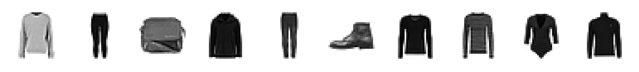

In [3]:
import matplotlib.pyplot as plt


def display(images, reshape=None, n=10, size=(8,6), cmap="gray_r", as_type="float32", save_to=None, style="seaborn-v0_8"):
    """
    Displays n random images from each one of the supplied arrays.
    """
    plt.style.use(style)

    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0


    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        img =  images[i]
        if reshape:
            img = img.reshape(reshape)

        plt.imshow(img.astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()


samples = next(train_ds.as_numpy_iterator())
display(samples['image'], reshape=input_shape)

# Define the model

In [4]:
dim_latent = 2

In [5]:
import jax
from flax import nnx
import itertools
from typing import Callable


class Encoder(nnx.Module):

    def __init__(self, dim_in: int, dim_out: int, *, activation: Callable, rngs: nnx.Rngs):

        self.layers = [

            # nnx.Conv(in_features=dim_in, out_features=32, kernel_size=(3,3), strides=2, padding="SAME", rngs=rngs),
            # activation,
            # nnx.Conv(in_features=32, out_features=32, kernel_size=(3,3), padding="SAME", rngs=rngs),
            # activation,
            # nnx.Conv(in_features=32, out_features=64, kernel_size=(3,3), strides=2, padding="SAME", rngs=rngs),
            # activation,
            # nnx.Conv(in_features=64, out_features=64, kernel_size=(3,3), padding="SAME", rngs=rngs),
            # activation,
            # nnx.Conv(in_features=64, out_features=64, kernel_size=(3,3), strides=2, padding="SAME", rngs=rngs),
            # activation,
            # lambda x: x.reshape(x.shape[0], -1),
            # nnx.Linear(in_features=4*4*64, out_features=dim_out, rngs=rngs),

            nnx.Linear(in_features=dim_in, out_features=512, rngs=rngs),
            activation,
            nnx.Linear(in_features=512, out_features=128, rngs=rngs),
            activation,
            nnx.Linear(in_features=128, out_features=dim_out, rngs=rngs)

        ]

    def __call__(self, x: jax.Array) -> jax.Array:
        return compose(*itertools.chain(self.layers))(x)

In [6]:
import jax.numpy as jnp
import math


encoder = Encoder(dim_in=math.prod(input_shape), dim_out=dim_latent, activation=nnx.relu, rngs=nnx.Rngs(0))
encoder(jnp.ones([batch_size, math.prod(input_shape)])).shape

W0000 00:00:1736312668.142489 11275792 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1736312668.151339 11275792 service.cc:145] XLA service 0x16d20e540 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736312668.151354 11275792 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1736312668.152630 11275792 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1736312668.152638 11275792 mps_client.cc:384] XLA backend will use up to 51539214336 bytes on device 0 for SimpleAllocator.


Metal device set to: Apple M2 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



(256, 2)

In [7]:
class Decoder(nnx.Module):

    def __init__(self, dim_in: int, dim_out: int, *, activation: Callable, rngs: nnx.Rngs):

        self.layers = [

            # nnx.Linear(in_features=dim_in, out_features=4*4*64, rngs=rngs),
            # activation,

            # lambda x: x.reshape(x.shape[0], 4, 4, -1),

            # nnx.ConvTranspose(in_features=64, out_features=64, kernel_size=(3,3), strides=(2,2), padding='SAME', rngs=rngs),
            # activation,

            # nnx.Conv(in_features=64, out_features=64, kernel_size=(3,3), padding='SAME', rngs=rngs),
            # activation,

            # nnx.ConvTranspose(in_features=64, out_features=32, kernel_size=(3,3), strides=(2,2), padding='SAME', rngs=rngs),
            # activation,

            # nnx.Conv(in_features=32, out_features=32, kernel_size=(3,3), padding='SAME', rngs=rngs),
            # activation,

            # nnx.ConvTranspose(in_features=32, out_features=dim_out, kernel_size=(3,3), strides=(2,2), padding='SAME', rngs=rngs),
            # nnx.sigmoid

            nnx.Linear(in_features=dim_in, out_features=128, rngs=rngs),
            activation,
            nnx.Linear(in_features=128, out_features=512, rngs=rngs),
            activation,
            nnx.Linear(in_features=512, out_features=dim_out, rngs=rngs),

        ]

    def __call__(self, x: jax.Array) -> jax.Array:
        return compose(*itertools.chain(self.layers))(x)

In [8]:
import jax.numpy as jnp

decoder = Decoder(dim_in=dim_latent, dim_out=math.prod(input_shape), activation=nnx.relu, rngs=nnx.Rngs(0))
decoder(jnp.ones([batch_size, dim_latent])).shape

(256, 1024)

# AutoEncoder

In [9]:
class AutoEncoder(nnx.Module):

    def __init__(self, dim_in: int, dim_emb: int, *, activation: Callable, rngs: nnx.Rngs):

        self.encoder = Encoder(dim_in, dim_emb, activation=activation, rngs=rngs)
        self.decoder = Decoder(dim_emb, dim_in, activation=activation, rngs=rngs)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def __call__(self, x: jax.Array) -> jax.Array:
        return compose(self.encode, self.decode)(x)

In [10]:
model = AutoEncoder(dim_in=math.prod(input_shape), dim_emb=2, activation=nnx.relu, rngs=nnx.Rngs(0))
nnx.display(model)

AutoEncoder(
  encoder=Encoder(
    layers=[Linear(
      kernel=Param(
        value=Array(shape=(1024, 512), dtype=float32)
      ),
      bias=Param(
        value=Array(shape=(512,), dtype=float32)
      ),
      in_features=1024,
      out_features=512,
      use_bias=True,
      dtype=None,
      param_dtype=<class 'jax.numpy.float32'>,
      precision=None,
      kernel_init=<function variance_scaling.<locals>.init at 0x16e9e25c0>,
      bias_init=<function zeros at 0x155446f20>,
      dot_general=<function dot_general at 0x154c0ca40>
    ), <jax._src.custom_derivatives.custom_jvp object at 0x1554ff7d0>, Linear(
      kernel=Param(
        value=Array(shape=(512, 128), dtype=float32)
      ),
      bias=Param(
        value=Array(shape=(128,), dtype=float32)
      ),
      in_features=512,
      out_features=128,
      use_bias=True,
      dtype=None,
      param_dtype=<class 'jax.numpy.float32'>,
      precision=None,
      kernel_init=<function variance_scaling.<locals>.init a

In [11]:
import jax.numpy as jnp

model(jnp.ones([batch_size, math.prod(input_shape)])).shape

(256, 1024)

# Optimizer

In [12]:
import optax

lr_schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=1e-3,
    warmup_steps=100,
    decay_steps=500*len(train_ds),
    end_value=1e-5
)
optimizer = nnx.Optimizer(
    model,
    optax.chain(
        optax.clip(1.0),  # Clip gradients at 1
        optax.adam(lr_schedule)
    )
)

# optimizer = nnx.Optimizer(model, optax.adam(learning_rate=0.001))

metric = nnx.metrics.Average()
nnx.display(metric)

Average(
  argname='values',
  total=MetricState(
    value=Array(0., dtype=float32)
  ),
  count=MetricState(
    value=Array(0, dtype=int32)
  )
)


# Define training steps

In [13]:
class Loss(nnx.Variable):
    pass

def loss_fn(model: AutoEncoder, batch: jax.Array):
    logits = model(batch["image"])
    losses = nnx.pop(model, Loss)
    kl_loss = sum(jax.tree_util.tree_leaves(losses), 0.0)
    reconstruction_loss = jnp.mean(
        optax.sigmoid_binary_cross_entropy(logits, batch["image"])
    )
    loss = reconstruction_loss + 0.1 * kl_loss
    return loss

In [14]:
@nnx.jit
def train_step(model: AutoEncoder, optimizer: nnx.Optimizer, metric: nnx.Metric, batch: jax.Array):
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=False)
    loss, grads = grad_fn(model, batch)
    metric.update(values=loss)
    optimizer.update(grads)

@nnx.jit
def eval_step(model: AutoEncoder, metric: nnx.Metric, batch: jax.Array):
    loss = loss_fn(model, batch)
    metric.update(values=loss)

# Train and evaluate the model

In [15]:
metric_history = {
    "train_loss": [],
    "test_loss": [],
}

num_batches_per_epoch = int(len(train_ds) / num_epochs)

epoch = 0
for i, batch in enumerate(train_ds.as_numpy_iterator(), start=1):

    train_step(model, optimizer, metric, batch)

    if i % num_batches_per_epoch == 0:
        epoch += 1

        # Log the training metric.
        value = metric.compute()
        metric_history[f"train_loss"].append(value)  # Record the metric.
        metric.reset()  # Reset the metric for the test set.

        # Compute the metric on the test set after each training epoch.
        for test_batch in test_ds.as_numpy_iterator():
            eval_step(model, metric, test_batch)

        # Log the test metric.
        value = metric.compute()
        metric_history[f'test_loss'].append(value)
        metric.reset()  # Reset the metric for the next training epoch.

        print(
            f"[train] epoch: {epoch}, "
            f"loss: {metric_history['train_loss'][-1]}",
        )

        print(
            f"[test] epoch: {epoch}, "
            f"loss: {metric_history['test_loss'][-1]}"
            '\n'
        )


[train] epoch: 1, loss: 0.3465558886528015
[test] epoch: 1, loss: 0.2737145721912384

[train] epoch: 2, loss: 0.2651751637458801
[test] epoch: 2, loss: 0.2613641917705536

[train] epoch: 3, loss: 0.25652015209198
[test] epoch: 3, loss: 0.2547864019870758

[train] epoch: 4, loss: 0.2526802122592926
[test] epoch: 4, loss: 0.25325167179107666

[train] epoch: 5, loss: 0.25038808584213257
[test] epoch: 5, loss: 0.2499038726091385

[train] epoch: 6, loss: 0.24870577454566956
[test] epoch: 6, loss: 0.2529800832271576

[train] epoch: 7, loss: 0.25393423438072205
[test] epoch: 7, loss: 0.2556327283382416

[train] epoch: 8, loss: 0.2496054619550705
[test] epoch: 8, loss: 0.2492159754037857

[train] epoch: 9, loss: 0.2490461766719818
[test] epoch: 9, loss: 0.2525002658367157

[train] epoch: 10, loss: 0.2473728507757187
[test] epoch: 10, loss: 0.24888022243976593

[train] epoch: 11, loss: 0.24693675339221954
[test] epoch: 11, loss: 0.24920733273029327

[train] epoch: 12, loss: 0.2464616447687149
[

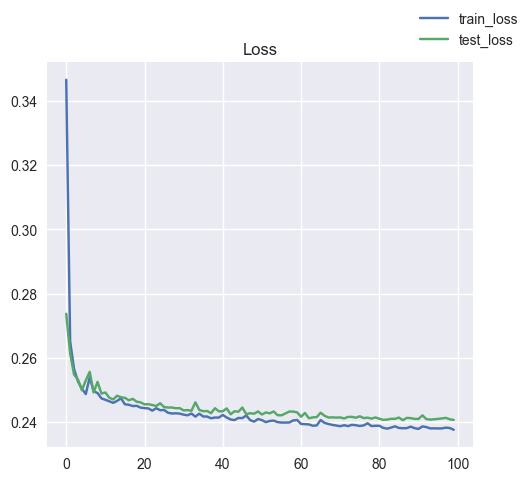

In [16]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig = plt.figure(figsize=(5.5, 5))
plt.title('Loss')
for dataset in ('train', 'test'):
    plt.plot(metric_history[f'{dataset}_loss'], label=f'{dataset}_loss')
fig.legend()
plt.show()

# Reconstruction

In [17]:
test_examples = test_batch['image']

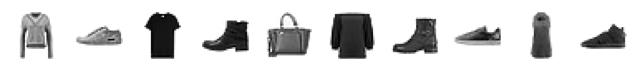

In [18]:
display(test_examples, reshape=input_shape)

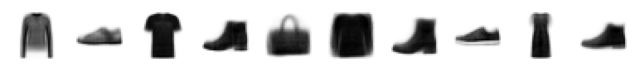

In [19]:
reconstructions = nnx.sigmoid(model(test_examples))
display(reconstructions, reshape=input_shape)

# Visualising the embedding space

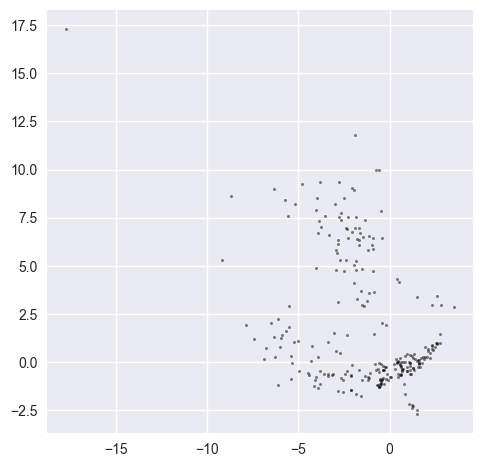

In [20]:
embeddings = model.encode(test_batch["image"])
plt.figure(figsize=(5.5, 5.5))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

# Reconstruction

In [84]:
import numpy as np


def get_samples(ds, num_samples=10):
    example_images = []; example_labels = []
    for i, samples in enumerate(test_ds.as_numpy_iterator()):
        example_images.append(samples["image"])
        example_labels.append(samples["label"])

        if i*batch_size >= n_to_predict:
            break
    return np.vstack(example_images)[:n_to_predict], np.hstack(example_labels)[:n_to_predict]

n_to_predict = 5_000
example_images, example_labels = get_samples(test_ds, num_samples=n_to_predict)

embeddings = model.encode(example_images)

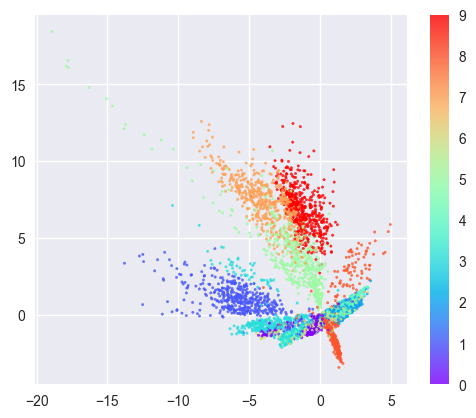

In [85]:
embeddings = model.encode(example_images)

figsize = 6
plt.figure(figsize=(figsize, figsize*0.8))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

## Generating new images

In [96]:
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# Sample some points in the latent space
grid_width, grid_height = (6, 2)
random_sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, dim_latent)
)

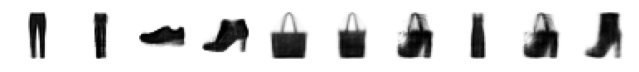

In [100]:
reconstructions = nnx.sigmoid(model.decode(random_sample)).reshape(-1, *input_shape)
display(reconstructions)

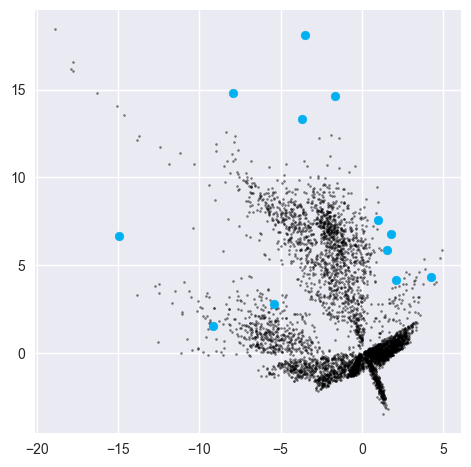

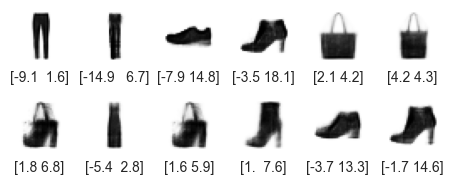

In [101]:
# Draw a plot of...
figsize = 5.5
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(random_sample[:, 0], random_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(random_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")